<a href="https://colab.research.google.com/github/Lyndon-Huang/numberThy/blob/main/Unet/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import np_utils
from keras.models import Model, load_model
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import cv2

from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import optimizers
from cv2 import imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
SEG_IMG_CHANNELS = 4

TRAIN_PATH = 'drive/My Drive/Colab Notebooks/keras_png_slices_data/keras_png_slices_train'#enter path to training data
TEST_PATH = 'drive/My Drive/Colab Notebooks/keras_png_slices_data/keras_png_slices_test'#enter path to testing data
VALIDATE_PATH = 'drive/My Drive/Colab Notebooks/keras_png_slices_data/keras_png_slices_validate'

SEG_TRAIN_PATH = 'drive/My Drive/Colab Notebooks/keras_png_slices_data/keras_png_slices_seg_train'#enter path to training data
SEG_TEST_PATH = 'drive/My Drive/Colab Notebooks/keras_png_slices_data/keras_png_slices_seg_test'#enter path to testing data
SEG_VALIDATE_PATH = 'drive/My Drive/Colab Notebooks/keras_png_slices_data/keras_png_slices_seg_validate'

# Get train and IDs
x_train_ids = next(os.walk(TRAIN_PATH))[2]
x_train_ids.sort()
x_train_ids = x_train_ids[:544]
x_test_ids = next(os.walk(TEST_PATH))[2]
x_test_ids.sort()
x_test_ids = x_test_ids[:544]
x_vaildate_ids = next(os.walk(VALIDATE_PATH))[2]
x_vaildate_ids.sort()
x_vaildate_ids = x_vaildate_ids[:544]

y_train_ids = next(os.walk(SEG_TRAIN_PATH))[2]
y_train_ids.sort()
y_train_ids = y_train_ids[:544]
y_test_ids = next(os.walk(SEG_TEST_PATH))[2]
y_test_ids.sort()
y_test_ids = y_test_ids[:544]
y_vaildate_ids = next(os.walk(SEG_VALIDATE_PATH))[2]
y_vaildate_ids.sort()
y_vaildate_ids = y_vaildate_ids[:544]



['case_001_slice_0.nii.png', 'case_001_slice_1.nii.png', 'case_001_slice_10.nii.png', 'case_001_slice_11.nii.png', 'case_001_slice_12.nii.png', 'case_001_slice_13.nii.png', 'case_001_slice_14.nii.png', 'case_001_slice_15.nii.png', 'case_001_slice_16.nii.png', 'case_001_slice_17.nii.png', 'case_001_slice_18.nii.png', 'case_001_slice_19.nii.png', 'case_001_slice_2.nii.png', 'case_001_slice_20.nii.png', 'case_001_slice_21.nii.png', 'case_001_slice_22.nii.png', 'case_001_slice_23.nii.png', 'case_001_slice_24.nii.png', 'case_001_slice_25.nii.png', 'case_001_slice_26.nii.png', 'case_001_slice_27.nii.png', 'case_001_slice_28.nii.png', 'case_001_slice_29.nii.png', 'case_001_slice_3.nii.png', 'case_001_slice_30.nii.png', 'case_001_slice_31.nii.png', 'case_001_slice_4.nii.png', 'case_001_slice_5.nii.png', 'case_001_slice_6.nii.png', 'case_001_slice_7.nii.png', 'case_001_slice_8.nii.png', 'case_001_slice_9.nii.png', 'case_002_slice_0.nii.png', 'case_002_slice_1.nii.png', 'case_002_slice_10.nii.pn

In [ ]:
def load_img(x):
  image = cv2.imread(x,cv2.IMREAD_GRAYSCALE)
  image = image.reshape(image.shape + (1,))
  image = (image - image.mean())/image.std()
  return image

def load_mask(x):
  mask = cv2.imread(x,cv2.IMREAD_GRAYSCALE)
  classes = np.unique(mask)
  res = np.zeros(mask.shape + (len(classes),))
  for i in range(len(classes)):
    c = classes[i]
    res[:,:,i][mask == c] = 1
  return res

In [ ]:
# Get and resize train images and masks
x_train = np.zeros((544, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
x_test = np.zeros((544, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
x_validate = np.zeros((544, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)

y_train = np.zeros((544, IMG_HEIGHT, IMG_WIDTH, SEG_IMG_CHANNELS), dtype=np.float32)
y_test = np.zeros((544, IMG_HEIGHT, IMG_WIDTH, SEG_IMG_CHANNELS), dtype=np.float32)
y_validate = np.zeros((544, IMG_HEIGHT, IMG_WIDTH, SEG_IMG_CHANNELS), dtype=np.float32)


In [ ]:
print('start')
for i in range(len(x_train_ids)):
  x_train[i] = load_img(TRAIN_PATH + "/" + x_train_ids[i])
for i in range(len(x_test_ids)):
  x_test[i] = load_img(TEST_PATH + "/" + x_test_ids[i])
for i in range(len(x_vaildate_ids)):
  x_validate[i] = load_img(VALIDATE_PATH + "/" + x_vaildate_ids[i])

for i in range(len(y_train_ids)):
  y_train[i] = load_mask(SEG_TRAIN_PATH + "/" + y_train_ids[i])
for i in range(len(y_test_ids)):
  y_test[i] = load_mask(SEG_TEST_PATH + "/" + y_test_ids[i])
for i in range(len(y_vaildate_ids)):
  y_validate[i] = load_mask(SEG_VALIDATE_PATH + "/" + y_vaildate_ids[i])
print("done!")
print(y_train.shape)

start
done!
(544, 256, 256, 4)


4


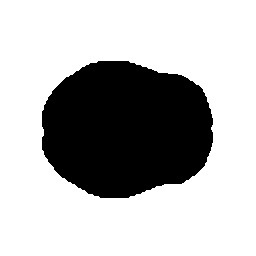

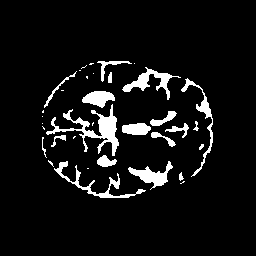

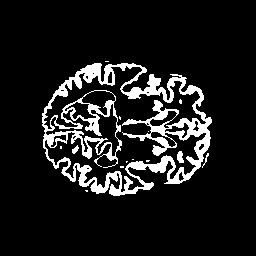

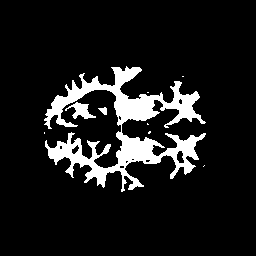

In [ ]:
from google.colab.patches import cv2_imshow
_,_,c= y_train[0].shape
print(c)
for i in range(c):
  s = y_train[0][:,:,i]
  s[s == 1] = 255
  cv2_imshow(s)

In [ ]:
#random.shuffle(x_train)
#random.shuffle(y_train)

In [ ]:
print("X_train",x_train.shape)
print("x_test",x_test.shape)
print("x_validate",x_validate.shape)
print("----------------------------------")
print("y_train",y_train.shape)
print("y_test",y_test.shape)
print("y_validate",y_validate.shape)


X_train (544, 256, 256, 1)
x_test (544, 256, 256, 1)
x_validate (544, 256, 256, 1)
----------------------------------
y_train (544, 256, 256, 4)
y_test (544, 256, 256, 4)
y_validate (544, 256, 256, 4)


In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
print(y_train.shape)

(544, 256, 256, 4)


In [ ]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='softmax') (c9)


model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 16) 0           conv2d_20[0][0]                  
_______________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.0001, verbose=1)
]

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=5,callbacks = callbacks,shuffle=True,
                    validation_data=(x_validate, y_validate))

Epoch 1/10
17/17 [==============================] - 70s 4s/step - loss: 0.7189 - accuracy: 0.7811 - val_loss: 0.3197 - val_accuracy: 0.8839
Epoch 2/10
17/17 [==============================] - 69s 4s/step - loss: 0.3093 - accuracy: 0.9238 - val_loss: 0.1441 - val_accuracy: 0.9497
Epoch 3/10
17/17 [==============================] - 69s 4s/step - loss: 0.2250 - accuracy: 0.9342 - val_loss: 0.1656 - val_accuracy: 0.9400
Epoch 4/10
17/17 [==============================] - 69s 4s/step - loss: 0.1930 - accuracy: 0.9456 - val_loss: 0.1144 - val_accuracy: 0.9571
Epoch 5/10
17/17 [==============================] - 69s 4s/step - loss: 0.1936 - accuracy: 0.9445 - val_loss: 0.1354 - val_accuracy: 0.9467
Epoch 6/10
17/17 [==============================] - 72s 4s/step - loss: 0.1378 - accuracy: 0.9630 - val_loss: 0.0907 - val_accuracy: 0.9645
Epoch 7/10
17/17 [==============================] - 69s 4s/step - loss: 0.1620 - accuracy: 0.9503 - val_loss: 0.1068 - val_accuracy: 0.9586
Epoch 8/10
17/17 [==

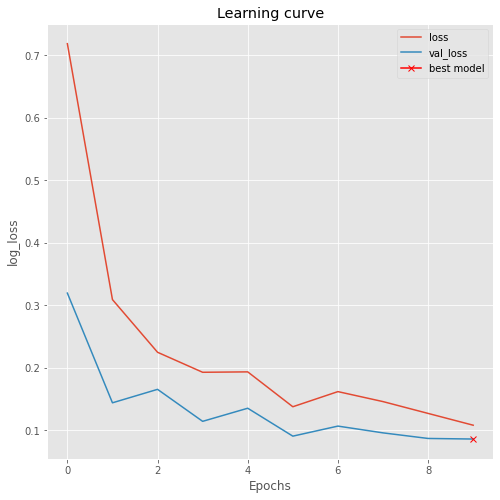

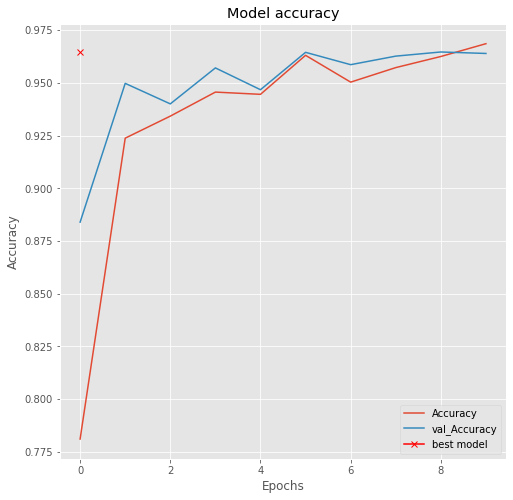

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title('Model accuracy')
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="val_Accuracy")
plt.plot( np.argmin(history.history["val_accuracy"]), np.max(history.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

In [ ]:
print('\nTesting ------------')
# Evaluate the cifar with the metrics we defined earlier
loss, accuracy = model.evaluate(x_test, y_test)

print('\ntest loss: ', loss)
print('\ntest accuracy: ', accuracy)


Testing ------------
17/17 [==============================] - 8s 442ms/step - loss: 0.0959 - accuracy: 0.9596

test loss:  0.09591839462518692

test accuracy:  0.9596028327941895


In [ ]:
# Predict on train, val and test
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_validate, verbose=1)
preds_test = model.predict(x_test,verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

17/17 [==============================] - 7s 422ms/step


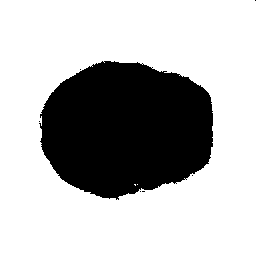

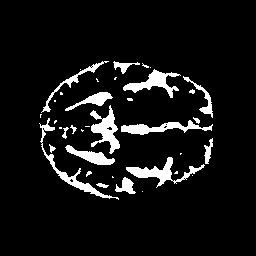

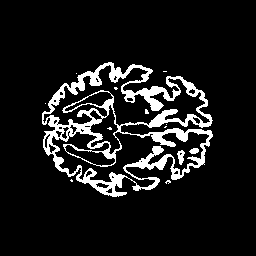

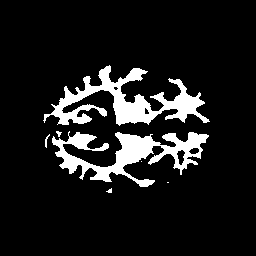

In [ ]:
_,_,c= preds_test_t[0].shape
for i in range(c):
  s = preds_test_t[0][:,:,i]
  s[s == 1] = 255
  cv2_imshow(s)

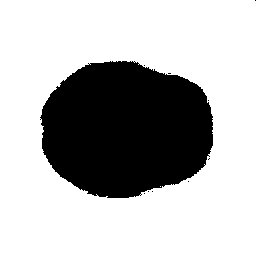

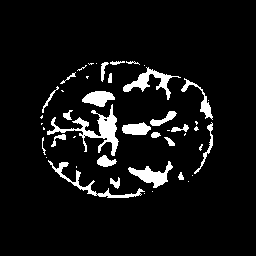

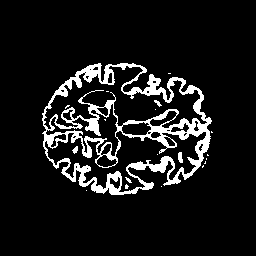

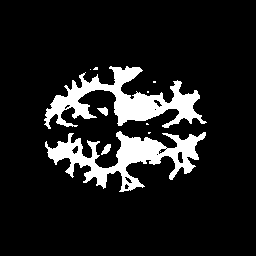

In [ ]:
_,_,c= preds_train_t[0].shape
for i in range(c):
  s = preds_train_t[0][:,:,i]
  s[s == 1] = 255
  cv2_imshow(s)

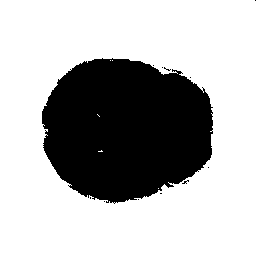

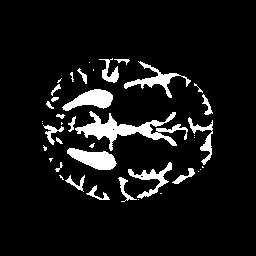

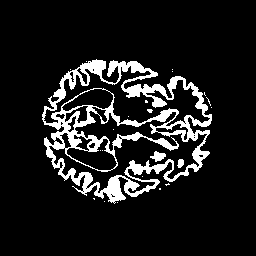

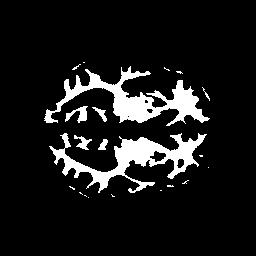

In [ ]:
_,_,c= preds_val_t[0].shape
for i in range(c):
  s = preds_val_t[0][:,:,i]
  s[s == 1] = 255
  cv2_imshow(s)